# Install Dependencies

In [26]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

# Annotate Images with LabelMe

In [2]:
!labelme

2024-04-09 22:08:22,311 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Gokuleshwaran\.labelmerc


# Build Image Loading Function

In [27]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

In [4]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)

In [5]:
images.as_numpy_iterator().next()

b'data\\images\\WIN_20240408_10_35_19_Pro.jpg'

In [6]:
# Load images into TF Data pipeline
def load_image(image_path):
    image = tf.io.read_file(image_path) # Read image from path
    image = tf.image.decode_jpeg(image) # Decode image to tensor, which converts it to a 3D tensor, with shape (height, width, channels)
    return image

In [7]:
images = images.map(load_image)

In [8]:
images.as_numpy_iterator().next()

array([[[125, 151, 140],
        [125, 151, 140],
        [125, 151, 142],
        ...,
        [ 97, 110, 126],
        [ 98, 110, 126],
        [ 98, 110, 126]],

       [[125, 151, 140],
        [125, 151, 140],
        [125, 151, 142],
        ...,
        [ 95, 111, 126],
        [ 97, 110, 126],
        [ 97, 110, 126]],

       [[125, 152, 143],
        [125, 152, 143],
        [125, 152, 143],
        ...,
        [ 94, 112, 124],
        [ 95, 111, 124],
        [ 96, 112, 125]],

       ...,

       [[ 54,  78,  65],
        [ 52,  76,  63],
        [ 50,  72,  60],
        ...,
        [ 41,  43,  32],
        [ 42,  44,  33],
        [ 42,  44,  33]],

       [[ 49,  77,  65],
        [ 48,  76,  64],
        [ 48,  74,  63],
        ...,
        [ 41,  41,  31],
        [ 41,  41,  31],
        [ 42,  42,  32]],

       [[ 45,  75,  65],
        [ 46,  76,  66],
        [ 49,  75,  64],
        ...,
        [ 39,  39,  29],
        [ 40,  40,  30],
        [ 40,  40,  30]]

In [9]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

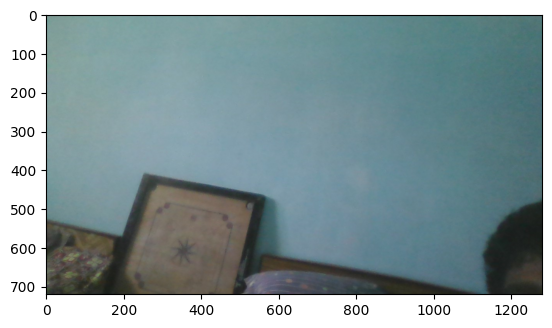

In [11]:
# View images with Matplotlib
plt.imshow(images.as_numpy_iterator().next())
plt.show()

# Partition UnAugmented Data

In [13]:
# 94*0.7 ~ 66
# 14 + 14 
import os

In [14]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

# Apply Image Augmentation on Images and Labels using Albumentations

In [18]:
# setup albumentations transfor pipeline
import albumentations as alb
augmentor = alb.Compose([
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.5),
    alb.RandomCrop(height=720, width=720),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2)],
    bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels'])) # the bbox_params is required to tell albumentations that the labels are in the 'class_labels' field

In [20]:
# Load a Test Image and Annotation with OpenCV and JSON
image = cv2.imread('data//test//images//WIN_20240409_21_46_00_Pro.jpg')
with open('data//test//labels//WIN_20240409_21_46_00_Pro.json') as f:
    annotation = json.load(f)

# Extract the bounding box coordinates
bboxes = []
for shape in annotation['shapes']:
    bboxes.append(shape['points'][0] + shape['points'][1])
    
bboxes

[[557.6136363636365, 85.56818181818184, 922.3863636363637, 563.9772727272727]]

In [ ]:
# display the image with bounding boxes
for bbox in bboxes:
    image = cv2.rectangle(image, tuple(map(int, bbox[:2])), tuple(map(int, bbox[2:])), (0, 255, 0), 2)

plt.imshow(image)
plt.show()

In [22]:
label = annotation
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords = list(np.divide(coords, [1280,720,1280,720]))
coords

[0.435635653409091, 0.118844696969697, 0.7206143465909092, 0.7833017676767677]

In [23]:
tuple(map(int, bbox[:2]))

(557, 85)

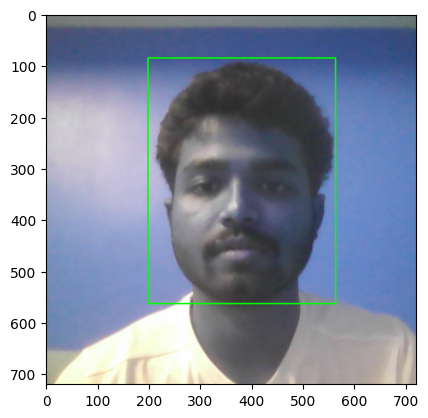

In [24]:
augmented = augmentor(image=image, bboxes=[coords], class_labels=['face'])
# display the image with bounding boxes
for bbox in augmented['bboxes']:
    image = cv2.rectangle(augmented['image'], tuple(map(int, bbox[:2])), tuple(map(int, bbox[2:])), (0, 255, 0), 2)
    
plt.imshow(image)
plt.show()

# bboxes
# bbox
# augmented

# Build and Run Augmentation Pipeline

In [25]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition,'images',image))
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                label = json.load(f)
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720])) 
        try:
            for x in range(60): # augment each image 60 times
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) # augment the image
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image']) # save the augmented image
                annotation = {}
                annotation['image'] = image 

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f: # save the annotation
                    json.dump(annotation, f) # save the annotation
        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6291725852272727, 0.5386679292929293, 0.40811434659090917, 0.0020517676767676956, 'face'].


# Load Augmented Images to Tensorflow Dataset

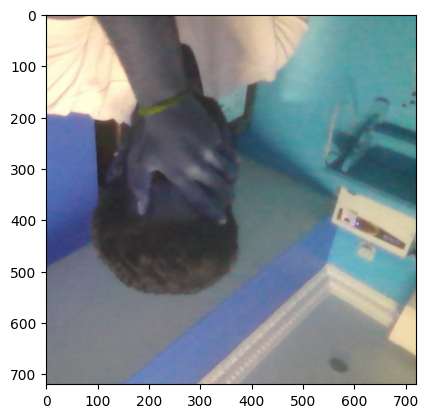

In [27]:
# display image 'aug_data\test\images\IMG-20240312-WA0008.2.jpg' with bounding boxes
image = cv2.imread('aug_data//test//images//WIN_20240408_10_35_19_Pro.4.jpg')
with open('aug_data//test//labels//WIN_20240408_10_35_19_Pro.4.json') as f:
    annotation = json.load(f)

# Extract the bounding box coordinates
bboxes = annotation['bbox']

image = cv2.rectangle(augmented['image'], tuple(map(int, bbox[:2])), tuple(map(int, bbox[2:])), (0, 255, 0), 2)
    
plt.imshow(image)
plt.show() 

In [28]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image) # Load images
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120))) # Resize images to 120x120
train_images = train_images.map(lambda x: x/255) # Normalize images
# note: train_images are in the format (batch, height, width, channels), numpy array

In [29]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image) # return image as tensor
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [30]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [31]:
len(train_images) # there are 3360 images in the train dataset

3960

In [32]:
train_images.as_numpy_iterator().next()

array([[[0.3745098 , 0.49215686, 0.45294118],
        [0.36862746, 0.4862745 , 0.44705883],
        [0.37745097, 0.5029412 , 0.4598039 ],
        ...,
        [0.5       , 0.5901961 , 0.5509804 ],
        [0.5009804 , 0.59117645, 0.55196077],
        [0.48921567, 0.59117645, 0.5480392 ]],

       [[0.36372548, 0.48137254, 0.45      ],
        [0.3745098 , 0.49607843, 0.46470588],
        [0.37156862, 0.49313724, 0.4617647 ],
        ...,
        [0.4852941 , 0.595098  , 0.5480392 ],
        [0.49117646, 0.6009804 , 0.5539216 ],
        [0.47058824, 0.5882353 , 0.5411765 ]],

       [[0.36372548, 0.4852941 , 0.4617647 ],
        [0.37156862, 0.5009804 , 0.4735294 ],
        [0.36666667, 0.49607843, 0.46862745],
        ...,
        [0.5058824 , 0.59705883, 0.55490196],
        [0.5009804 , 0.59411764, 0.55196077],
        [0.49215686, 0.59411764, 0.54901963]],

       ...,

       [[0.1392157 , 0.10490196, 0.06764706],
        [0.13529412, 0.10392157, 0.04803922],
        [0.14607844, 0

# Prepare Labels

In [33]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [34]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False) # this will be the path to the json file

In [35]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False) # this will be the path to the json file
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16])) # Load labels, note: the labels are in the format (class, bbox)

In [36]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

In [37]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [38]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [39]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

In [40]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3960, 3960, 780, 780, 840, 840)

# Combine Label and Image Samples

In [41]:
train = tf.data.Dataset.zip((train_images, train_labels)) # Combine images and labels, this will be the input to the model
train = train.shuffle(5000) # Shuffle the dataset, this is important because the model will learn better if the data is shuffled
train = train.batch(8) # batch size of 8
train = train.prefetch(4) # prefetch 4 batches, this is a good number to start with, you can increase it later. It means that while the model is training on one batch, the next 4 batches are being prepared in the background.

In [42]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [43]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [44]:
# save the processed data
tf.data.Dataset.save(train, 'train')
tf.data.Dataset.save(test, 'test')
tf.data.Dataset.save(val, 'val')

In [45]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [15]:
# test = tf.data.Dataset.load('test', element_spec=(tf.TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (tf.TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), tf.TensorSpec(shape=<unknown>, dtype=tf.float16, name=None))))
test = tf.data.Dataset.load('test', element_spec=(tf.TensorSpec(shape=(8, 120, 120, 3), dtype=tf.float32, name=None), (tf.TensorSpec(shape=(None,1), dtype=tf.uint8, name=None), tf.TensorSpec(shape=(None, 4), dtype=tf.float16, name=None))))
train = tf.data.Dataset.load('train', element_spec=(tf.TensorSpec(shape=(8, 120, 120, 3), dtype=tf.float32, name=None), (tf.TensorSpec(shape=(None,1), dtype=tf.uint8, name=None), tf.TensorSpec(shape=(None, 4), dtype=tf.float16, name=None))))
val = tf.data.Dataset.load('val', element_spec=(tf.TensorSpec(shape=(8, 120, 120, 3), dtype=tf.float32, name=None), (tf.TensorSpec(shape=(None,1), dtype=tf.uint8, name=None), tf.TensorSpec(shape=(None, 4), dtype=tf.float16, name=None))))


In [47]:
test.as_numpy_iterator().next()

(array([[[[0.40098038, 0.40098038, 0.35392156],
          [0.4117647 , 0.40392157, 0.35686275],
          [0.41666666, 0.40490195, 0.3754902 ],
          ...,
          [0.7392157 , 0.6333333 , 0.5647059 ],
          [0.7323529 , 0.622549  , 0.5392157 ],
          [0.73137254, 0.6215686 , 0.5392157 ]],
 
         [[0.40784314, 0.41568628, 0.36078432],
          [0.4       , 0.40784314, 0.3529412 ],
          [0.40588236, 0.40980393, 0.35490197],
          ...,
          [0.74313724, 0.62352943, 0.5470588 ],
          [0.74313724, 0.62352943, 0.53039217],
          [0.7392157 , 0.6215686 , 0.527451  ]],
 
         [[0.40392157, 0.40392157, 0.35686275],
          [0.40392157, 0.40392157, 0.3627451 ],
          [0.40686274, 0.4019608 , 0.35      ],
          ...,
          [0.7607843 , 0.6313726 , 0.5647059 ],
          [0.75686276, 0.622549  , 0.5441176 ],
          [0.7392157 , 0.6137255 , 0.53137255]],
 
         ...,
 
         [[0.21176471, 0.19607843, 0.19215687],
          [0.21078

In [48]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.10046, 0.2988 , 0.432  , 0.6743 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1412 , 0.3445 , 0.438  , 0.717  ],
        [0.305  , 0.3699 , 0.66   , 0.769  ],
        [0.10815, 0.1647 , 0.5894 , 0.859  ],
        [0.     , 0.3413 , 0.561  , 0.9663 ],
        [0.4866 , 0.3113 , 0.851  , 0.7373 ],
        [0.721  , 0.2625 , 1.     , 0.6885 ]], dtype=float16))

In [49]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [50]:
train.as_numpy_iterator().next()[0]

array([[[[0.5568628 , 0.37745097, 0.31176472],
         [0.54901963, 0.38431373, 0.2872549 ],
         [0.5509804 , 0.39019608, 0.28039217],
         ...,
         [0.64117646, 0.6098039 , 0.5980392 ],
         [0.64705884, 0.6156863 , 0.6039216 ],
         [0.6431373 , 0.6117647 , 0.6       ]],

        [[0.55      , 0.3852941 , 0.29313725],
         [0.5470588 , 0.39019608, 0.2882353 ],
         [0.54313725, 0.39803922, 0.28627452],
         ...,
         [0.64509803, 0.6137255 , 0.60588235],
         [0.6490196 , 0.61764705, 0.6098039 ],
         [0.64509803, 0.6137255 , 0.60588235]],

        [[0.54901963, 0.3745098 , 0.28039217],
         [0.54509807, 0.38039216, 0.2901961 ],
         [0.5470588 , 0.38627452, 0.2901961 ],
         ...,
         [0.654902  , 0.62058824, 0.6215686 ],
         [0.65686274, 0.622549  , 0.62352943],
         [0.6480392 , 0.6137255 , 0.61470586]],

        ...,

        [[0.2784314 , 0.29117647, 0.29607844],
         [0.31176472, 0.32156864, 0.327451  ]

# Build Deep Learning Network

In [30]:
from tensorflow.keras import Model
from tensorflow.keras.layers import  Dense, Input, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [31]:
# Create a base model
base_model = VGG16(include_top=False)

In [32]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    # Add the base model
    vgg = VGG16(include_top=False)(input_layer)
    
    # Classifier
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding Box
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    model = Model(inputs=input_layer, outputs=[class2, regress2])
    
    return model

In [34]:
# test the model
facetracker = build_model()
X , y = train.as_numpy_iterator().next()

In [35]:
X.shape

(8, 120, 120, 3)

In [36]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


In [37]:
classes, coords

(array([[0.4276098 ],
        [0.46270177],
        [0.52230525],
        [0.4465158 ],
        [0.4268309 ],
        [0.4064123 ],
        [0.52828074],
        [0.44890636]], dtype=float32),
 array([[0.5889082 , 0.54266644, 0.46571878, 0.3744759 ],
        [0.5610039 , 0.6236665 , 0.38603878, 0.26220796],
        [0.55136126, 0.6445997 , 0.39843068, 0.25653443],
        [0.5956664 , 0.55381083, 0.4283756 , 0.41563827],
        [0.5898613 , 0.58179057, 0.4158598 , 0.2972507 ],
        [0.5714309 , 0.6137408 , 0.42395613, 0.32952976],
        [0.56928086, 0.6427843 , 0.4368278 , 0.33883685],
        [0.65399545, 0.56742346, 0.46323457, 0.4345621 ]], dtype=float32))

# Define Losses and Optimizers

In [38]:
# Define optimizer and LR
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [39]:
lr_decay

0.0006734006734006732

In [40]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay) # Adam optimizer with learning rate of 0.0001

c:\Users\Gokuleshwaran\Desktop\35-Projects\28. Face Detection\.venv\lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [41]:
def localization_loss(y_true, yhat): # Custom loss function, this is the loss function for the bounding box
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [42]:
regressloss = localization_loss

In [43]:
# classloss = tf.keras.losses.BinaryCrossentropy() # Binary crossentropy loss function for the classification
def classloss(y_true, yhat):
    # Cast y_true to the same data type as yhat
    y_true = tf.cast(y_true, yhat.dtype)
    
    # Compute the squared difference between y_true and yhat
    loss = tf.reduce_sum(tf.square(y_true - yhat))
    
    return loss


In [44]:
classes, y[0]


(array([[0.4276098 ],
        [0.46270177],
        [0.52230525],
        [0.4465158 ],
        [0.4268309 ],
        [0.4064123 ],
        [0.52828074],
        [0.44890636]], dtype=float32),
 array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8))

In [45]:
coords, y[1]

(array([[0.5889082 , 0.54266644, 0.46571878, 0.3744759 ],
        [0.5610039 , 0.6236665 , 0.38603878, 0.26220796],
        [0.55136126, 0.6445997 , 0.39843068, 0.25653443],
        [0.5956664 , 0.55381083, 0.4283756 , 0.41563827],
        [0.5898613 , 0.58179057, 0.4158598 , 0.2972507 ],
        [0.5714309 , 0.6137408 , 0.42395613, 0.32952976],
        [0.56928086, 0.6427843 , 0.4368278 , 0.33883685],
        [0.65399545, 0.56742346, 0.46323457, 0.4345621 ]], dtype=float32),
 array([[0.10046, 0.2988 , 0.432  , 0.6743 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1412 , 0.3445 , 0.438  , 0.717  ],
        [0.305  , 0.3699 , 0.66   , 0.769  ],
        [0.10815, 0.1647 , 0.5894 , 0.859  ],
        [0.     , 0.3413 , 0.561  , 0.9663 ],
        [0.4866 , 0.3113 , 0.851  , 0.7373 ],
        [0.721  , 0.2625 , 1.     , 0.6885 ]], dtype=float16))

In [46]:
# test the loss functions
classloss(y[0], classes), regressloss(y[1], coords)

(<tf.Tensor: shape=(), dtype=float32, numpy=2.2833529>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.434104>)

In [47]:
classes.shape

(8, 1)

In [48]:
y[0].shape

(8, 1)

# Create Custom Model Class

In [49]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, (class_labels, bounding_boxes) = batch
        
        # print contents of  batch
        
        
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
           
            batch_classloss = self.closs(class_labels, classes)
            batch_localizationloss = self.lloss(tf.cast(bounding_boxes, tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [50]:
facetracker = build_model()
facetracker = FaceTracker(facetracker)
facetracker.compile(opt, classloss, regressloss)

# Callbacks

In [51]:
# tensorboard
from tensorflow.keras.callbacks import TensorBoard
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)

In [52]:
# a batch of data
# X , y = train.as_numpy_iterator().next()

In [53]:
y[0] # convert to tensor


array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [ ]:
hist = facetracker.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
facetracker.save('my_model', save_format="tf")

# Testing and Evaluation

In [68]:
from tensorflow.keras.models import load_model

In [69]:
import tensorflow as tf

In [ ]:
# prompt: predicts on test data
model = facetracker_loaded
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

yhat = model.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)


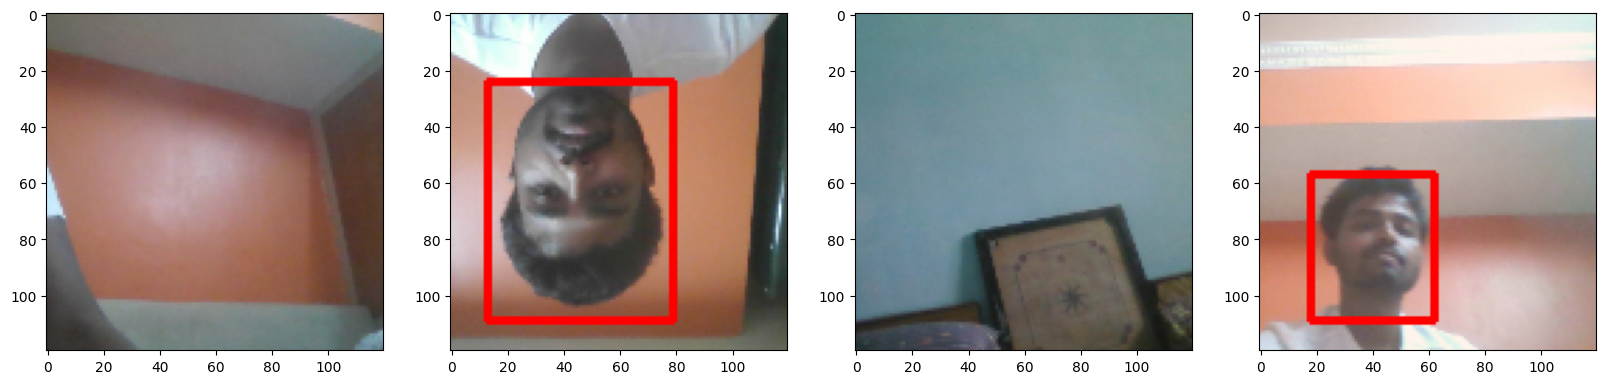

# Realtime Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()